This code reads GOSAT1 L2 XCO2 SWATH data prepares a 2.5x2.5 gridded data. You can customize the resultant grid based on your choice

In [30]:
reset -f

In [1]:
import warnings
warnings.filterwarnings("ignore")
import glob,os

import xarray as xr
import numpy as np
import pandas as pd
import calendar
from datetime import datetime, timedelta

from pyresample.geometry import GridDefinition, SwathDefinition
from pyresample.kd_tree import resample_nearest

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

In [5]:
def Swath2Grid(diri,start_date,end_date):
    '''
    This function converts GOSAT2 L2 XCO2 swath data to
    a gridded data for easy model evaluation and other analysis
    inputs:
    diri: SWIRL2CO2 data directory
    start_date: start of the analysis
    end_date: end of the analysis
    '''
    # Column-averaged XCO2 product
    processed_data = {}
    not_exist = []
    Time_stamp = []
    Data_prep = {}
    count = 0
    current_date = start_date
    while current_date <= end_date:
        #print('Processing Data at '+current_date.strftime('%Y-%m-%d'))
        fili = 'GOSATTFTS'+str(current_date.year)+str(current_date.month).zfill(2)+\
        str(current_date.day).zfill(2)+'_02C01SV0305R'+current_date.strftime('%y%m%d')+'GU000.h5'
        print(fili)
        if os.path.isfile(diri+fili):
            Time_stamp.append(current_date.strftime('%Y-%m-%d'))
            ds = xr.open_dataset(diri+fili,group='Data/mixingRatio')
            ds_co2 = ds['XCO2BiasCorrected']; ds_co2[ds_co2<0]=np.nan
            ds = xr.open_dataset(diri+fili,group='Data/geolocation')
            lats = ds['latitude']
            lons = ds['longitude']
            # Regridding the data into a 2D grid
            # Define SwathDefinition.
            swathDef = SwathDefinition(lons=lons.values, lats=lats.values)
            # Define GridDefinition.
            interv = 2.5
            min_lon = -180
            max_lon = 180
            min_lat = -90
            max_lat = 90
            x0, xinc, y0, yinc = (min_lon, interv, max_lat, -interv)
            nx = int(np.floor((max_lon - min_lon) / interv))
            ny = int(np.floor((max_lat - min_lat) / interv))
            x = np.linspace(x0, x0 + xinc*nx, nx)
            y = np.linspace(y0, y0 + yinc*ny, ny)
            lon_g, lat_g = np.meshgrid(x, y)
            grid_def = GridDefinition(lons=lon_g, lats=lat_g)
            # Set radius_of_influence in meters.
            ri = 100000   # 100 km
            result = resample_nearest(swathDef, ds_co2.values, grid_def, radius_of_influence=ri, 
                                      epsilon=0.5,fill_value=np.nan)

            Data_prep[count+1] = result
            count = count+1
        else:
            not_exist.append(fili)
        current_date += timedelta(days=1)
    #
    return Data_prep, Time_stamp,y,x,not_exist

In [11]:
idir = '/Volumes/NIES-Work/NISMON-CO2/Analysis/4dvar_gosat/2024_GR/GOSAT-data/SWIRL2CO2/'
sdate = datetime(2009, 4, 23); edate = datetime(2009, 4, 30)
data,times,lats,lons,no_data = Swath2Grid(idir,sdate,edate)
#
# Preparing xarray data and writing for future usage
Data_np = np.zeros([len(data),lats.shape[0],lons.shape[0]])
for day in list(data.keys()):
    Data_np[day-1] = data[day]
ds = xr.Dataset({'xco2': xr.DataArray(
                data = Data_np,   # ppm
                dims = ['time','lat','lon'],
                coords = {'time':pd.DatetimeIndex(times),'lat':lats,'lon': lons},
                attrs  = {'units':'ppm','long_name':'Daily column-averaged CO2'}),},attrs = {'Source': 
                                                     'GOSAT FTS SWIR L2 Column-averaged Product',
                                                    'Prepared by': 'Suman Maity'})
ds['lon'].attrs = {'long_name': 'Longitude', 'units': 'degrees_east'}
ds['lat'].attrs = {'long_name': 'Latitude', 'units': 'degrees_north'}
#ds.to_netcdf('GOSATFTS_SWIR_2009-2020.nc')

GOSATTFTS20090423_02C01SV0305R090423GU000.h5
GOSATTFTS20090424_02C01SV0305R090424GU000.h5
GOSATTFTS20090425_02C01SV0305R090425GU000.h5
GOSATTFTS20090426_02C01SV0305R090426GU000.h5
GOSATTFTS20090427_02C01SV0305R090427GU000.h5
GOSATTFTS20090428_02C01SV0305R090428GU000.h5
GOSATTFTS20090429_02C01SV0305R090429GU000.h5
GOSATTFTS20090430_02C01SV0305R090430GU000.h5


In [13]:
ds['xco2']

<xarray.DataArray 'xco2' (time: 8, lat: 72, lon: 144)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 2009-04-23 2009-04-24 ... 2009-04-30
  * lat      (lat) float64 90.0 87.46 84.93 82.39 ... -82.39 -84.93 -87.46 -90.0
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.4 ... 175.0 177.5 180.0
Attributes:
    units:      ppm
    long_name:  Daily column-averaged CO2

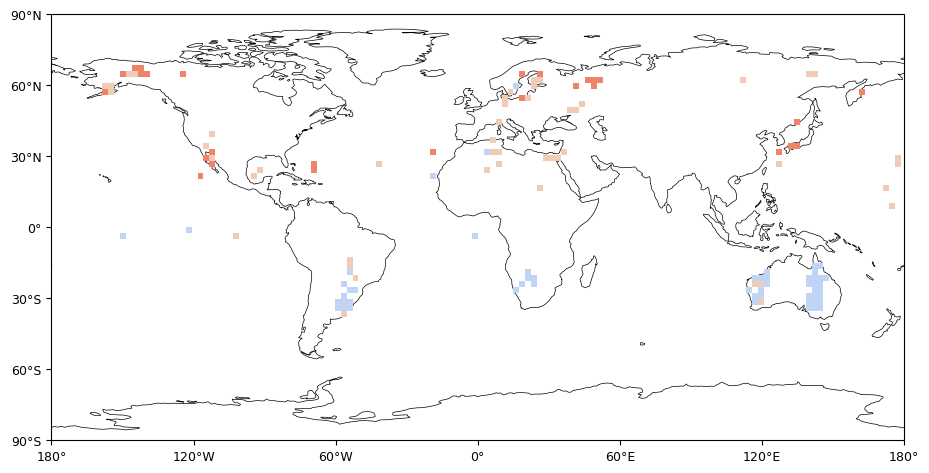

In [14]:
levels_diff = np.arange(370,400.1,5)
cmap1 = plt.get_cmap('coolwarm')
norm1 = BoundaryNorm(levels_diff, ncolors=cmap1.N, clip=True)

fig, ax = plt.subplots(nrows=1,ncols=1,subplot_kw={'projection':ccrs.PlateCarree()},
                        figsize=(11,8.5))
ax.set_global()
ax.coastlines(lw=0.5)
ax.tick_params(axis='both', which='major', labelsize=9)
ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

cs = ax.pcolormesh(ds['xco2'].lon, ds['xco2'].lat,ds['xco2'][7], cmap=cmap1,norm = norm1)

In [ ]:
ß